In [1]:
# !pip install plotly
# !pip install pandas
import pandas as pd
# !pip install pandas_ta
# import pandas_ta as ta
import numpy as np
# !pip install seaborn
import seaborn as sns
import datetime
from datetime import timedelta
import math
import requests
import plotly as py
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px



import sklearn as sk
import sklearn.preprocessing
from sklearn import metrics
from matplotlib.pyplot import figure

from sklearn.preprocessing import  (StandardScaler, MinMaxScaler, LabelBinarizer)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression
import xgboost as xgb
from sklearn.metrics import *
# from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import tree
from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

# !pip install keras
# !pip install tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional

# !pip install graphviz
# import graphviz
# import chart_studio.tools as tls

# Creating DataFrame

In [2]:
#manipulatable variables
numDaysBack = str(365*5) #for daily you can go back multiple years worth, for daily you can only go back 90 days
myInterval = 'daily' # options are daily or hourly
theCoins = ['ethereum'] #can add more than one coin if you like
window_length = 14
mycom = 0.4
lower_macd_ema = 12
upper_macd_ema = 26
trigger_macd_ema = 9


def df_builder_clean(days, interval, coins):
    #manipulatable variables
    numDaysBack = days #for daily you can go back multiple years worth, for daily you can only go back 90 days
    myInterval = interval # options are daily or hourly
    theCoins = coins

    #builds initial dataframe with ethereum as first market but just to log the dates we are working with
    geckoReq = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days='+numDaysBack+'&interval='+myInterval+''
    r = requests.get(geckoReq).json()
    ts = r['prices'][0][0]
    ts = ts/1000
    HistPricesList = []
    for i in range(len(r['prices'])):
        currentUnix = r['prices'][i][0] 
        price = r['prices'][i][1]
        currentUnix = currentUnix/1000
#         currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%d-%m-%Y %H:%M:%S") #adding dd-mm-yyyy hours minutes seconds
        currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%m-%d-%Y") #just the date mm-dd-yyyy
        HistPricesList.append([currentTS])
    global df
    df = pd.DataFrame(HistPricesList, columns = ['date'])

    
    #looping through each coin and adding in all data points and input variables
    for coin in theCoins:
        price_data(coin)
#         add_ewm(coin, mycom)
#         add_rsi(coin, window_length)
#         add_macd(coin, lower_macd_ema, upper_macd_ema, trigger_macd_ema)
        print('just added: ', coin)
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
#     print('r')
#     display(r)
    return df


def price_data(coin):
    global df
    # geckoReq = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days=60&interval=daily'
    geckoReq = 'https://api.coingecko.com/api/v3/coins/'+coin+'/market_chart?vs_currency=usd&days='+numDaysBack+'&interval='+myInterval+''

    r = requests.get(geckoReq).json()
    ts = r['prices'][0][0]
    # print(ts)
    ts = ts/1000
    print(datetime.datetime.fromtimestamp(ts).strftime("%m-%d-%Y"))
    # print('prices length',len(r['prices']))
    HistPricesList = []
    for i in range(len(r['prices'])):
        currentUnix = r['prices'][i][0] 
        price = r['prices'][i][1]
        volume = r['total_volumes'][i][1]
        currentUnix = currentUnix/1000
        currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%m-%d-%Y")
    #     print('price: ', price, 'TS: ', currentTS)
        HistPricesList.append([currentTS, price, volume])
    #     currentUnix = currentTS
#         print(HistPricesList)
    dfCoin = pd.DataFrame(HistPricesList, columns = ['date', coin, coin+'_volume'])
#     print('dfCoin')
#     display(dfCoin)
    df = pd.merge(df, dfCoin[coin], left_on = df['date'], right_on=dfCoin['date']).drop(['key_0'], axis = 1)
    df = pd.merge(df, dfCoin[coin+'_volume'], left_on = df['date'], right_on=dfCoin['date']).drop(['key_0'], axis = 1)
    
def add_ewm(coin, mycom):
    df[coin+'_ewm'] = df[coin].ewm(com=mycom).mean()
    
def add_rsi(coin, window_length):
    global df
    df['diff'] = df[coin].diff(1)
    df['gain'] = df['diff'].clip(lower=0).round(2)
    df['loss'] = df['diff'].clip(upper=0).abs().round(2)
    
    # Get initial Averages
    df['avg_gain'] = df['gain'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
    df['avg_loss'] = df['loss'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]

    # Get WMS averages
    # Average Gains
    for i, row in enumerate(df['avg_gain'].iloc[window_length+1:]):
        df['avg_gain'].iloc[i + window_length + 1] =\
            (df['avg_gain'].iloc[i + window_length] *
             (window_length - 1) +
             df['gain'].iloc[i + window_length + 1])\
            / window_length
    # Average Losses
    for i, row in enumerate(df['avg_loss'].iloc[window_length+1:]):
        df['avg_loss'].iloc[i + window_length + 1] =\
            (df['avg_loss'].iloc[i + window_length] *
             (window_length - 1) +
             df['loss'].iloc[i + window_length + 1])\
            / window_length
        
    df['rs'] = df['avg_gain'] / df['avg_loss']
    
    df['rsi'] = 100 - (100 / (1.0 + df['rs']))
    df = pd.DataFrame(df)
    df = df.drop(['gain', 'loss', 'avg_loss', 'avg_gain', 'rs'], axis = 1)
    
    #renaming diff and rsi columns
    dict = {'diff': coin+'_diff',
        'rsi': coin+'_rsi'}
    df.rename(columns=dict,
              inplace=True)

def add_macd(coin, lower_macd_ema, upper_macd_ema, trigger_macd_ema):
    global df
    #get ema for lower
    k = df[coin].ewm(span=lower_macd_ema, adjust = False, min_periods = lower_macd_ema).mean()

    #get ema for upper
    d = df[coin].ewm(span=upper_macd_ema, adjust=False, min_periods=upper_macd_ema).mean()

    macd = k-d
    
    # Get the 9-Day EMA of the MACD for the Trigger line
    macd_s = macd.ewm(span=trigger_macd_ema, adjust=False, min_periods=trigger_macd_ema).mean()
    # Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
    macd_h = macd - macd_s
    # Add all of our new values for the MACD to the dataframe
    df['macd'] = df.index.map(macd)
    df['macd_h'] = df.index.map(macd_h)
    df['macd_s'] = df.index.map(macd_s)



mydf = pd.DataFrame(df_builder_clean(numDaysBack, myInterval, theCoins))
display(mydf)



08-17-2017
just added:  ethereum


,ethereum,ethereum_volume
date,,
2017-08-17,296.114635,5.904704e+08
2017-08-18,296.622090,5.537022e+08
2017-08-19,295.171577,3.428230e+08
2017-08-20,322.201220,1.743910e+09
2017-08-21,312.174471,8.983443e+08
...,...,...
2022-08-12,1959.330925,1.584926e+10
2022-08-13,1982.411828,1.481675e+10
2022-08-14,1936.701164,1.217221e+10


In [3]:
mydf.dropna(inplace=True)
# myCols = ['ethereum', 'ethereum_volume', 'ethereum_ewm', 'ethereum_rsi', 'macd', 'macd_h', 'macd_s', 'ethereum_diff']

In [4]:
my_data = mydf
# display(my_data.tail(10))
# my_data.drop(my_data.tail(10).index,
#         inplace = True)
display(my_data)

,ethereum,ethereum_volume
date,,
2017-08-17,296.114635,5.904704e+08
2017-08-18,296.622090,5.537022e+08
2017-08-19,295.171577,3.428230e+08
2017-08-20,322.201220,1.743910e+09
2017-08-21,312.174471,8.983443e+08
...,...,...
2022-08-12,1959.330925,1.584926e+10
2022-08-13,1982.411828,1.481675e+10
2022-08-14,1936.701164,1.217221e+10


In [27]:

fig = px.line(my_data, y="ethereum", title='Ethereum Historical Price')

fig.show()

## Train Test Split Sliding Window

### Bull LSTM

In [6]:
#bull
bull = pd.DataFrame(my_data)

bull = bull.reset_index()
display(bull)
bull['date'] = pd.to_datetime(bull['date'])
mask = bull['date'] <= '2021-12-01'
bull = bull.loc[mask]
bull = bull.set_index('date')


fig = px.line(bull, y="ethereum", title='Ethereum ending in Bull Market')
fig.show()

#stag
stag = pd.DataFrame(my_data)

stag = bull.reset_index()
display(bull)
stag['date'] = pd.to_datetime(stag['date'])
mask = stag['date'] <= '2020-07-17'
stag = stag.loc[mask]
stag = stag.set_index('date')

fig = px.line(stag, y="ethereum", title='Ethereum ending in stag Market')
fig.show()

#bear
bear = pd.DataFrame(my_data)

bear = bear.reset_index()
display(bear)
bear['date'] = pd.to_datetime(bear['date'])
mask = bear['date'] <= '2022-07-12'
bear = bear.loc[mask]
bear = bear.set_index('date')


fig = px.line(bear, y="ethereum", title='Ethereum ending in Bear Market')
fig.show()


,date,ethereum,ethereum_volume
0,2017-08-17,296.114635,5.904704e+08
1,2017-08-18,296.622090,5.537022e+08
2,2017-08-19,295.171577,3.428230e+08
3,2017-08-20,322.201220,1.743910e+09
4,2017-08-21,312.174471,8.983443e+08
...,...,...,...
1821,2022-08-12,1959.330925,1.584926e+10
1822,2022-08-13,1982.411828,1.481675e+10
1823,2022-08-14,1936.701164,1.217221e+10
1824,2022-08-15,1908.277642,1.831087e+10


,ethereum,ethereum_volume
date,,
2017-08-17,296.114635,5.904704e+08
2017-08-18,296.622090,5.537022e+08
2017-08-19,295.171577,3.428230e+08
2017-08-20,322.201220,1.743910e+09
2017-08-21,312.174471,8.983443e+08
...,...,...
2021-11-27,4084.088486,1.650051e+10
2021-11-28,4290.091863,1.740861e+10
2021-11-29,4444.528280,2.015092e+10


,date,ethereum,ethereum_volume
0,2017-08-17,296.114635,5.904704e+08
1,2017-08-18,296.622090,5.537022e+08
2,2017-08-19,295.171577,3.428230e+08
3,2017-08-20,322.201220,1.743910e+09
4,2017-08-21,312.174471,8.983443e+08
...,...,...,...
1821,2022-08-12,1959.330925,1.584926e+10
1822,2022-08-13,1982.411828,1.481675e+10
1823,2022-08-14,1936.701164,1.217221e+10
1824,2022-08-15,1908.277642,1.831087e+10


,ethereum,ethereum_volume
date,,
2017-08-17,296.114635,5.904704e+08
2017-08-18,296.622090,5.537022e+08
2017-08-19,295.171577,3.428230e+08
2017-08-20,322.201220,1.743910e+09
2017-08-21,312.174471,8.983443e+08
...,...,...
2021-11-27,4084.088486,1.650051e+10
2021-11-28,4290.091863,1.740861e+10
2021-11-29,4444.528280,2.015092e+10


,ethereum,ethereum_volume
date,,
2017-08-17,296.114635,5.904704e+08
2017-08-18,296.622090,5.537022e+08
2017-08-19,295.171577,3.428230e+08
2017-08-20,322.201220,1.743910e+09
2017-08-21,312.174471,8.983443e+08
...,...,...
2020-07-13,239.638787,5.773854e+09
2020-07-14,240.251471,4.794731e+09
2020-07-15,238.663597,4.622070e+09


,ethereum,ethereum_volume
date,,
2017-08-17,296.114635,5.904704e+08
2017-08-18,296.622090,5.537022e+08
2017-08-19,295.171577,3.428230e+08
2017-08-20,322.201220,1.743910e+09
2017-08-21,312.174471,8.983443e+08
...,...,...
2022-07-08,1233.514679,1.534660e+10
2022-07-09,1216.849707,7.870255e+09
2022-07-10,1169.012708,1.037447e+10


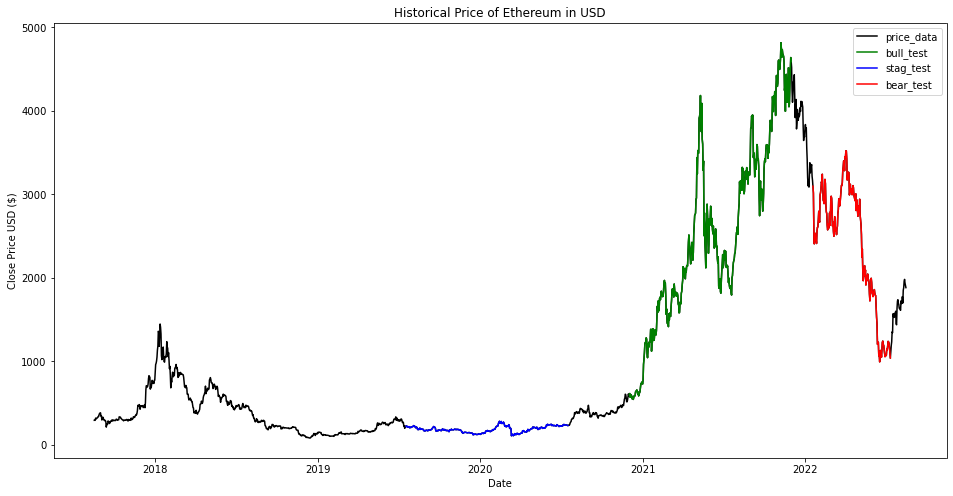

change in bull test:  6.6651846166110404
change in bear test:  -0.6639360892689741
change in stag test:  0.052768029873276785


In [50]:
display(bull)
bull_test = bull.tail(365)
stag_test = stag.tail(365)
bear_test = bear.tail(175)
display(stag)
display(bear)
plt.figure(figsize=(16,8))
plt.title('Historical Price of Ethereum in USD')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(my_data['ethereum'], color='k', label='price_data')
plt.plot(bull_test['ethereum'], color='g', label='bull_test')
plt.plot(stag_test['ethereum'], color='b', label='stag_test')
plt.plot(bear_test['ethereum'], color='r', label='bear_test')
# plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.legend()
plt.show()
bull_T_first = bull_test.head(1).values[0][0]
bull_T_last = bull_test.tail(1).values[0][0]

bear_T_first = bear_test.head(1).values[0][0]
bear_T_last = bear_test.tail(1).values[0][0]

stag_T_first = stag_test.head(1).values[0][0]
stag_T_last = stag_test.tail(1).values[0][0]

print('change in bull test: ', (bull_T_last-bull_T_first)/bull_T_first)

print('change in bear test: ', (bear_T_last-bear_T_first)/bear_T_first)


print('change in stag test: ', (stag_T_last-stag_T_first)/stag_T_first)


In [7]:
seq=list(mydf['ethereum'])
# display(seq)
# scaler = StandardScaler()
scaler = MinMaxScaler(feature_range = (0, 1))
window_size = 15
my_target = window_size-1
sliding_window=[]
for i in range(len(seq) - window_size + 1):
    sliding_window.append(seq[i: i + window_size])
    
# print(sliding_window)

sliding_df = pd.DataFrame(sliding_window)

sliding_df = sliding_df.drop(columns=[11,12,13])
display(sliding_df)

dataset = sliding_df

# We want 80% of the data to be used for training, and 20% for testing
n_train_rows = int(dataset.shape[0]*.8)-1

# Split into train and test sets but keep all 9 columns
train = dataset.iloc[:n_train_rows, :]
test = dataset.iloc[n_train_rows:, :]

# The total rows of the two datasets should equal the total amount of rows in your CSV
print(train.shape)
print(test.shape)

# Normalise features
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train.values)
test_set_scaled = sc.fit_transform(test.values)

,0,1,2,3,4,5,6,7,8,9,10,14
0,296.114635,296.622090,295.171577,322.201220,312.174471,316.788920,321.785298,329.025281,329.865783,343.341337,344.201131,386.343057
1,296.622090,295.171577,322.201220,312.174471,316.788920,321.785298,329.025281,329.865783,343.341337,344.201131,366.809590,346.398775
2,295.171577,322.201220,312.174471,316.788920,321.785298,329.025281,329.865783,343.341337,344.201131,366.809590,378.906331,349.929240
3,322.201220,312.174471,316.788920,321.785298,329.025281,329.865783,343.341337,344.201131,366.809590,378.906331,382.934451,299.717332
4,312.174471,316.788920,321.785298,329.025281,329.865783,343.341337,344.201131,366.809590,378.906331,382.934451,386.343057,318.972804
...,...,...,...,...,...,...,...,...,...,...,...,...
1807,1739.042177,1696.785098,1682.011374,1636.018556,1638.378683,1621.341324,1612.418907,1725.382627,1693.296592,1699.006418,1775.701356,1959.330925
1808,1696.785098,1682.011374,1636.018556,1638.378683,1621.341324,1612.418907,1725.382627,1693.296592,1699.006418,1775.701356,1698.966129,1982.411828
1809,1682.011374,1636.018556,1638.378683,1621.341324,1612.418907,1725.382627,1693.296592,1699.006418,1775.701356,1698.966129,1852.878555,1936.701164
1810,1636.018556,1638.378683,1621.341324,1612.418907,1725.382627,1693.296592,1699.006418,1775.701356,1698.966129,1852.878555,1881.427405,1908.277642


(1448, 12)
(364, 12)


In [8]:
display(bull)

,ethereum,ethereum_volume
date,,
2017-08-17,296.114635,5.904704e+08
2017-08-18,296.622090,5.537022e+08
2017-08-19,295.171577,3.428230e+08
2017-08-20,322.201220,1.743910e+09
2017-08-21,312.174471,8.983443e+08
...,...,...
2021-11-27,4084.088486,1.650051e+10
2021-11-28,4290.091863,1.740861e+10
2021-11-29,4444.528280,2.015092e+10


In [9]:
# close_prices = stock_data['Close']
# values = close_prices.values
values = bull['ethereum'].values
# print(values)
training_data_len = math.ceil(len(values)- 365)
print('training_data: ', training_data_len)
print('len values', len(values))
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

print(y_train)
# print(y_train)

test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_test)

training_data:  1203
len values 1568
[0.04948244 0.04875501 0.04749067 ... 0.10377139 0.11170015 0.10690605]
[[[0.0554205 ]
  [0.05678724]
  [0.05702938]
  ...
  [0.10377139]
  [0.11170015]
  [0.10690605]]

 [[0.05678724]
  [0.05702938]
  [0.05428412]
  ...
  [0.11170015]
  [0.10690605]
  [0.10884609]]

 [[0.05702938]
  [0.05428412]
  [0.05445908]
  ...
  [0.10690605]
  [0.10884609]
  [0.11259693]]

 ...

 [[0.61922889]
  [0.68086497]
  [0.69963756]
  ...
  [0.83795046]
  [0.84551208]
  [0.88905337]]

 [[0.68086497]
  [0.69963756]
  [0.70649897]
  ...
  [0.84551208]
  [0.88905337]
  [0.92169536]]

 [[0.69963756]
  [0.70649897]
  [0.69887373]
  ...
  [0.88905337]
  [0.92169536]
  [0.96240228]]]


In [10]:
model = keras.Sequential()
model.add(keras.layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(100, return_sequences=False))
# model.add(keras.layers.Dense(12, activation="relu", name="layer2"))
# model.add(keras.layers.Dense(1, activation='sigmoid')) # Produces probabilities


model.add(keras.layers.Dense(25))
model.add(keras.layers.Dense(1))

model.summary()

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=9)


predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
predictions_train = model.predict(x_train)
predictions_train = scaler.inverse_transform(predictions_train)
y_train = np.reshape(y_train, (y_train.shape[0], 1))

y_train = scaler.inverse_transform(y_train)

rmse_train = np.sqrt(np.mean(predictions_train - y_train)**2)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print('rmse train: ', rmse_train)
print('rmse test: ', rmse)

print('r2_score train: ', r2_score(y_train, predictions_train))
print('r2_score test: ', r2_score(y_test, predictions))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________
Epoch 1/9
1143/1143 [==============================] - 18s 14ms/step - loss: 2.9711e-04
Epoch 2/9
1143/1143 [==============================] - 18s 15ms/step - loss: 1.7430e-04
Epoch 

C:\Users\fooba\AppData\Local\Temp/ipykernel_21496/2387018754.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



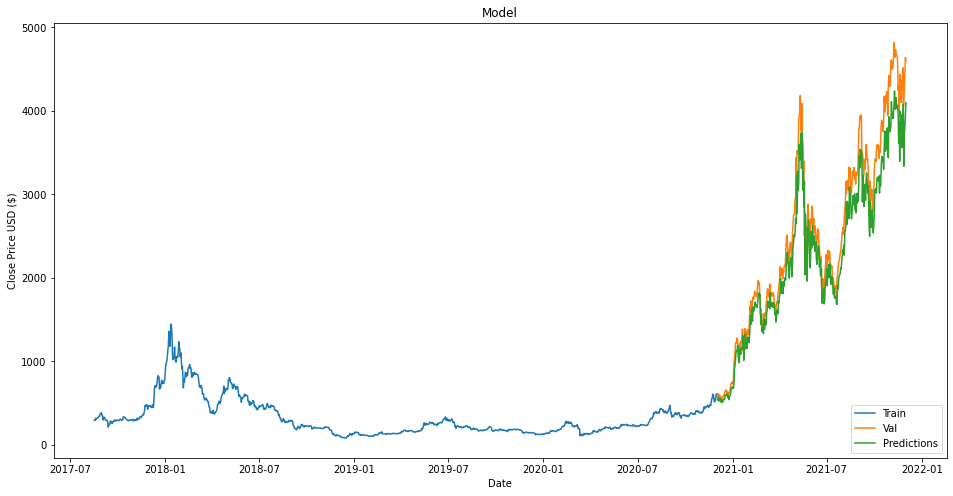

C:\Users\fooba\AppData\Local\Temp/ipykernel_21496/2387018754.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



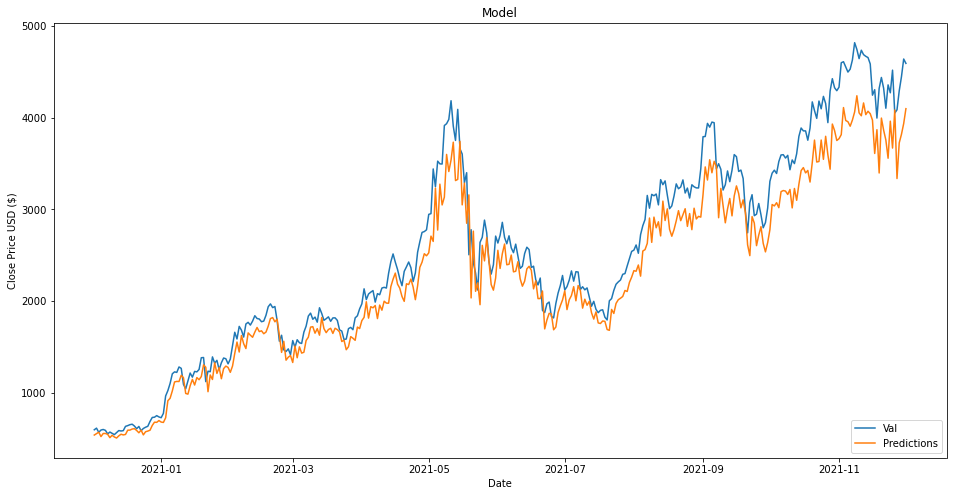

In [11]:
data = bull.filter(['ethereum'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions 
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['ethereum', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()


data = bull.filter(['ethereum'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions 
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
# plt.plot(train)
plt.plot(validation[['ethereum', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

In [12]:
# buy when prediction is below price, and sell when prediction is above price
# validation['buy'] = if validation['ethereum'] > validation['Predictions']

moneyStart = 1000
money = moneyStart
eth = money/validation['ethereum'].iloc[1]



validation['buy'] = np.where(validation['ethereum'] > validation['Predictions'], 1, 0)
# validation['sell'] = np.where(validation['ethereum'] < validation['Predictions'], 1, 0)
validation['signal'] = validation['buy'].diff()
validation['money'] = moneyStart

validation = validation.iloc[1:, :]
validation['eth'] = moneyStart/eth
display(validation.head(5))


for index, row in validation.iterrows():
    if row['signal'] == 1:
#         print('buy')
#         print('money: ',  money, 'price: ', row['ethereum'])
        eth = money/row['ethereum']
        validation.loc[index, 'eth'] = eth
        validation.loc[index, 'money'] = money


        row['eth'] = eth
    elif row['signal'] == -1:
#         print('sell')
        money = eth*row['ethereum']
        validation.loc[index, 'eth'] = eth
        validation.loc[index, 'money'] = money
    else:
        validation.loc[index, 'eth'] = eth
        validation.loc[index, 'money'] = money
        
display(validation)
#     print(moneyStart/row['Close'])


C:\Users\fooba\AppData\Local\Temp/ipykernel_21496/2261137071.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\fooba\AppData\Local\Temp/ipykernel_21496/2261137071.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\fooba\AppData\Local\Temp/ipykernel_21496/2261137071.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

,ethereum,Predictions,buy,signal,money,eth
date,,,,,,
2020-12-03,616.506662,556.392212,1,0.0,1000,616.506662
2020-12-04,571.190432,572.232422,0,-1.0,1000,616.506662
2020-12-05,595.919414,524.712402,1,1.0,1000,616.506662
2020-12-06,601.968935,558.290588,1,0.0,1000,616.506662
2020-12-07,592.386507,558.533508,1,0.0,1000,616.506662


,ethereum,Predictions,buy,signal,money,eth
date,,,,,,
2020-12-03,616.506662,556.392212,1,0.0,1000.000000,1.622042
2020-12-04,571.190432,572.232422,0,-1.0,926.495150,1.622042
2020-12-05,595.919414,524.712402,1,1.0,926.495150,1.554732
2020-12-06,601.968935,558.290588,1,0.0,926.495150,1.554732
2020-12-07,592.386507,558.533508,1,0.0,926.495150,1.554732
...,...,...,...,...,...,...
2021-11-27,4084.088486,3335.356201,1,1.0,4578.928778,1.121163
2021-11-28,4290.091863,3723.946777,1,0.0,4578.928778,1.121163
2021-11-29,4444.528280,3816.771729,1,0.0,4578.928778,1.121163


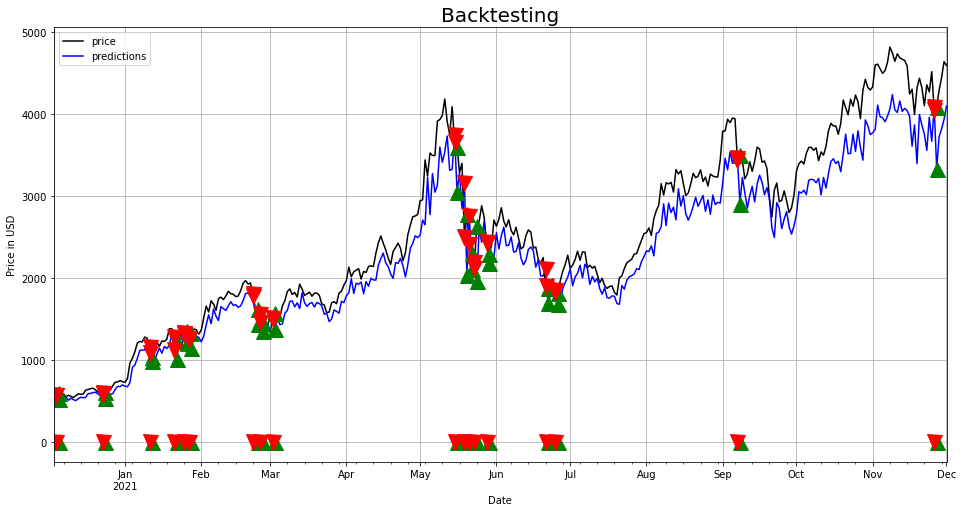

In [13]:
validation = validation[['ethereum', 'Predictions', 'signal']]
plt.figure(figsize = (16, 8))
validation['ethereum'].plot(color='k', label = 'price')
validation['Predictions'].plot(color='b', label='predictions')
plt.plot(validation[validation['signal']==1].index, validation[validation['signal']==1],'^', markersize = 15, color='g')
plt.plot(validation[validation['signal']==-1].index, validation[validation['signal']==-1],'v', markersize = 15, color='r')
plt.ylabel('Price in USD')
plt.xlabel('Date')
plt.title('Backtesting', fontsize = 20)
plt.legend()
plt.grid()
plt.show()


### LSTM STAGNANT


In [14]:
# close_prices = stock_data['Close']
# values = close_prices.values
values = stag['ethereum'].values
# print(values)
training_data_len = math.ceil(len(values)- 365)
print('training_data: ', training_data_len)
print('len values', len(values))
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

print(y_train)
# print(y_train)

test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_test)

training_data:  701
len values 1066
[1.71586967e-01 1.69064486e-01 1.64680218e-01 1.60196039e-01
 1.58977439e-01 1.55162121e-01 1.50710164e-01 1.57556946e-01
 1.57357761e-01 1.55323076e-01 1.56951106e-01 1.55877973e-01
 1.61210873e-01 1.63049294e-01 1.61065011e-01 1.52847753e-01
 1.48991925e-01 1.62751588e-01 1.58435854e-01 1.56649283e-01
 1.59473592e-01 1.54976592e-01 1.65016853e-01 1.74834789e-01
 1.59461967e-01 1.70385064e-01 1.68851625e-01 1.69714887e-01
 1.87007303e-01 1.83598687e-01 1.80472306e-01 1.82912905e-01
 1.94197005e-01 1.97633340e-01 2.06685773e-01 2.03218304e-01
 2.16669868e-01 2.40965307e-01 2.86732437e-01 2.81194723e-01
 2.82332011e-01 2.93593072e-01 2.86132083e-01 2.52536620e-01
 2.71457501e-01 2.82966271e-01 2.82961559e-01 2.77115324e-01
 2.84717419e-01 2.80879765e-01 2.67182520e-01 2.69745826e-01
 2.81513746e-01 2.91887476e-01 2.65982599e-01 3.11651089e-01
 4.23671841e-01 4.58882973e-01 4.55026792e-01 4.46579981e-01
 4.53284458e-01 4.72674646e-01 5.23550658e-01 5.4

In [15]:
#stag
model = keras.Sequential()
model.add(keras.layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(100, return_sequences=False))
model.add(keras.layers.Dense(25))
model.add(keras.layers.Dense(1))
model.summary()

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=9)


predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
predictions_train = model.predict(x_train)
predictions_train = scaler.inverse_transform(predictions_train)
y_train = np.reshape(y_train, (y_train.shape[0], 1))

y_train = scaler.inverse_transform(y_train)

rmse_train = np.sqrt(np.mean(predictions_train - y_train)**2)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print('rmse train: ', rmse_train)
print('rmse test: ', rmse)

print('r2_score train: ', r2_score(y_train, predictions_train))
print('r2_score test: ', r2_score(y_test, predictions))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 25)                2525      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________
Epoch 1/9
641/641 [==============================] - 12s 15ms/step - loss: 0.0034
Epoch 2/9
641/641 [==============================] - 10s 15ms/step - loss: 0.0022
Epoch 3/9
641/64

C:\Users\fooba\AppData\Local\Temp/ipykernel_21496/2938302244.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



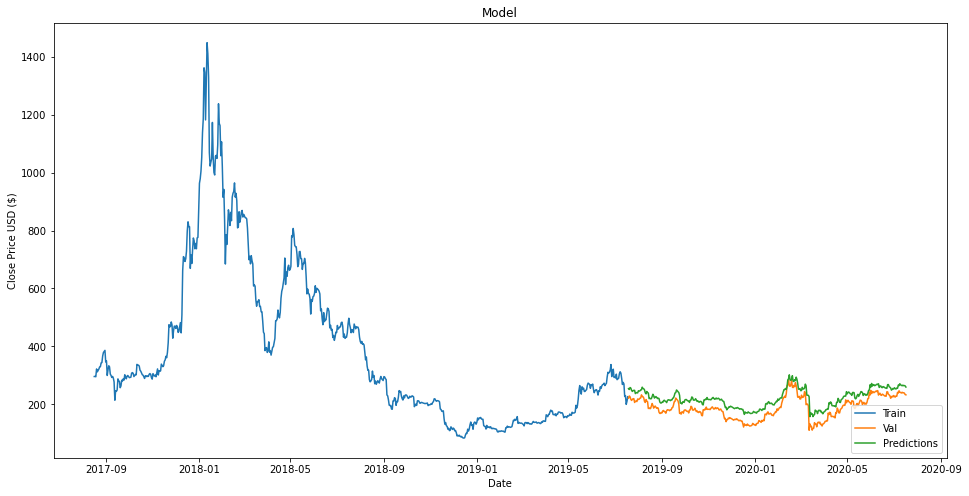

C:\Users\fooba\AppData\Local\Temp/ipykernel_21496/2938302244.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



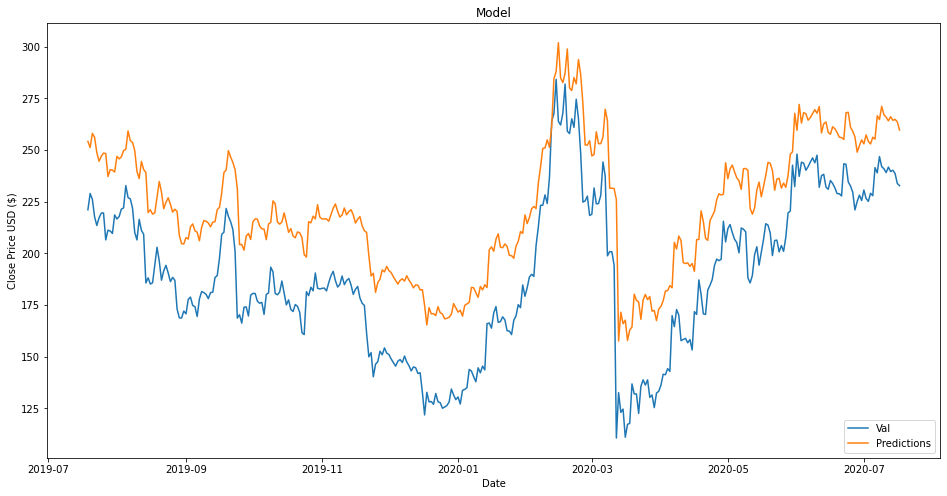

In [16]:
#stag
data = stag.filter(['ethereum'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['ethereum', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()


data = stag.filter(['ethereum'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions 
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
# plt.plot(train)
plt.plot(validation[['ethereum', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

In [17]:
#stag

moneyStart = 1000
money = moneyStart
eth = money/validation['ethereum'].iloc[1]



validation['buy'] = np.where(validation['ethereum'] > validation['Predictions'], 1, 0)
# validation['sell'] = np.where(validation['ethereum'] < validation['Predictions'], 1, 0)
validation['signal'] = validation['buy'].diff()
validation['money'] = moneyStart

validation = validation.iloc[1:, :]
validation['eth'] = moneyStart/eth
display(validation.head(5))


for index, row in validation.iterrows():
    if row['signal'] == 1:
#         print('buy')
#         print('money: ',  money, 'price: ', row['ethereum'])
        eth = money/row['ethereum']
        validation.loc[index, 'eth'] = eth
        validation.loc[index, 'money'] = money


        row['eth'] = eth
    elif row['signal'] == -1:
#         print('sell')
        money = eth*row['ethereum']
        validation.loc[index, 'eth'] = eth
        validation.loc[index, 'money'] = money
    else:
        validation.loc[index, 'eth'] = eth
        validation.loc[index, 'money'] = money
        
display(validation)
#     print(moneyStart/row['Close'])


C:\Users\fooba\AppData\Local\Temp/ipykernel_21496/3781293657.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\fooba\AppData\Local\Temp/ipykernel_21496/3781293657.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\fooba\AppData\Local\Temp/ipykernel_21496/3781293657.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

,ethereum,Predictions,buy,signal,money,eth
date,,,,,,
2019-07-20,228.964804,251.210114,0,0.0,1000,228.964804
2019-07-21,226.153408,258.115814,0,0.0,1000,228.964804
2019-07-22,217.652562,256.174744,0,0.0,1000,228.964804
2019-07-23,213.502152,248.780853,0,0.0,1000,228.964804
2019-07-24,217.197778,244.596375,0,0.0,1000,228.964804


,ethereum,Predictions,buy,signal,money,eth
date,,,,,,
2019-07-20,228.964804,251.210114,0,0.0,1000.000000,4.367483
2019-07-21,226.153408,258.115814,0,0.0,1000.000000,4.367483
2019-07-22,217.652562,256.174744,0,0.0,1000.000000,4.367483
2019-07-23,213.502152,248.780853,0,0.0,1000.000000,4.367483
2019-07-24,217.197778,244.596375,0,0.0,1000.000000,4.367483
...,...,...,...,...,...,...
2020-07-13,239.638787,266.173553,0,0.0,1013.777367,3.787409
2020-07-14,240.251471,264.406189,0,0.0,1013.777367,3.787409
2020-07-15,238.663597,264.891296,0,0.0,1013.777367,3.787409


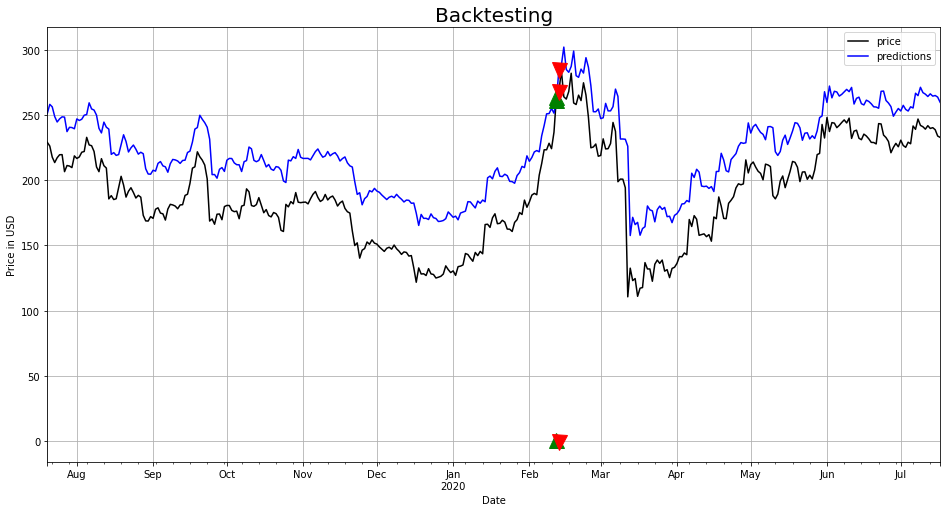

In [18]:
#stag
validation = validation[['ethereum', 'Predictions', 'signal']]
plt.figure(figsize = (16, 8))
validation['ethereum'].plot(color='k', label = 'price')
validation['Predictions'].plot(color='b', label='predictions')
plt.plot(validation[validation['signal']==1].index, validation[validation['signal']==1],'^', markersize = 15, color='g')
plt.plot(validation[validation['signal']==-1].index, validation[validation['signal']==-1],'v', markersize = 15, color='r')
plt.ylabel('Price in USD')
plt.xlabel('Date')
plt.title('Backtesting', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

### LSTM Bear

In [19]:
# close_prices = stock_data['Close']
# values = close_prices.values
values = bear['ethereum'].values
# print(values)
training_data_len = math.ceil(len(values)- 175)
print('training_data: ', training_data_len)
print('len values', len(values))
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

print(y_train)
# print(y_train)

test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_test)

training_data:  1616
len values 1791
[0.04948244 0.04875501 0.04749067 ... 0.69168426 0.66215646 0.65155897]
[[[0.91993355]
  [0.89523987]
  [0.84909982]
  ...
  [0.69168426]
  [0.66215646]
  [0.65155897]]

 [[0.89523987]
  [0.84909982]
  [0.90286146]
  ...
  [0.66215646]
  [0.65155897]
  [0.63688358]]

 [[0.84909982]
  [0.90286146]
  [0.88468776]
  ...
  [0.65155897]
  [0.63688358]
  [0.61967181]]

 ...

 [[0.42211625]
  [0.39797636]
  [0.40717376]
  ...
  [0.24445973]
  [0.243009  ]
  [0.23948666]]

 [[0.39797636]
  [0.40717376]
  [0.41859054]
  ...
  [0.243009  ]
  [0.23948666]
  [0.22937573]]

 [[0.40717376]
  [0.41859054]
  [0.43609514]
  ...
  [0.23948666]
  [0.22937573]
  [0.21424997]]]


In [20]:
#bear
model = keras.Sequential()
model.add(keras.layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(100, return_sequences=False))
model.add(keras.layers.Dense(25))
model.add(keras.layers.Dense(1))
model.summary()

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=9)


predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
predictions_train = model.predict(x_train)
predictions_train = scaler.inverse_transform(predictions_train)
y_train = np.reshape(y_train, (y_train.shape[0], 1))

y_train = scaler.inverse_transform(y_train)

rmse_train = np.sqrt(np.mean(predictions_train - y_train)**2)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print('rmse train: ', rmse_train)
print('rmse test: ', rmse)

print('r2_score train: ', r2_score(y_train, predictions_train))
print('r2_score test: ', r2_score(y_test, predictions))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dense_4 (Dense)             (None, 25)                2525      
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________
Epoch 1/9
1556/1556 [==============================] - 27s 16ms/step - loss: 0.0022
Epoch 2/9
1556/1556 [==============================] - 24s 15ms/step - loss: 0.0015
Epoch 3/9
15

C:\Users\fooba\AppData\Local\Temp/ipykernel_21496/2836514432.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



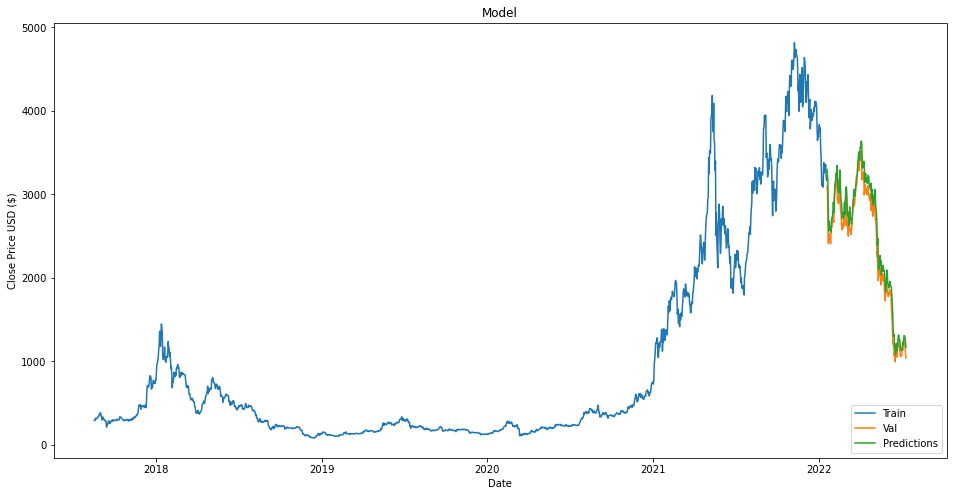

C:\Users\fooba\AppData\Local\Temp/ipykernel_21496/2836514432.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



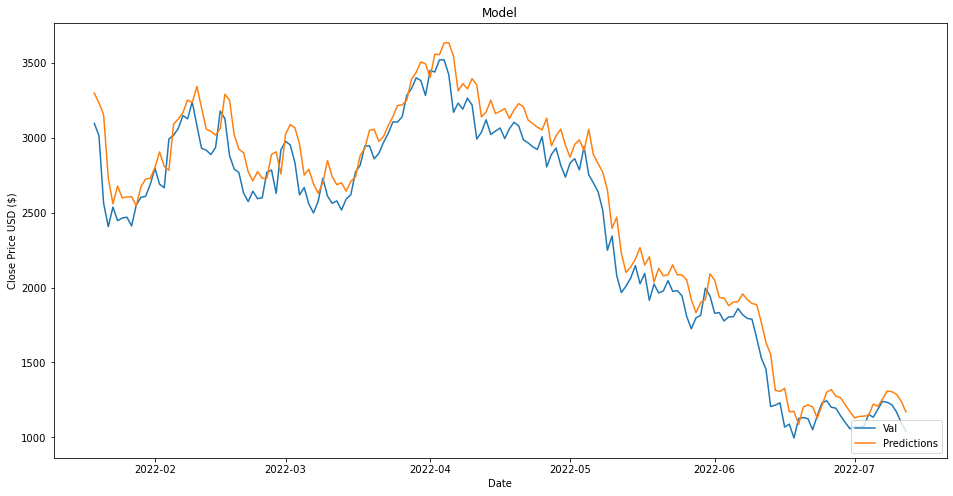

In [21]:
#bear
data = bear.filter(['ethereum'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions 
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['ethereum', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()


data = bear.filter(['ethereum'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions 
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
# plt.plot(train)
plt.plot(validation[['ethereum', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

In [22]:
#bear

moneyStart = 1000
money = moneyStart
eth = money/validation['ethereum'].iloc[1]



validation['buy'] = np.where(validation['ethereum'] > validation['Predictions'], 1, 0)
# validation['sell'] = np.where(validation['ethereum'] < validation['Predictions'], 1, 0)
validation['signal'] = validation['buy'].diff()
validation['money'] = moneyStart

validation = validation.iloc[1:, :]
validation['eth'] = moneyStart/eth
display(validation.head(5))


for index, row in validation.iterrows():
    if row['signal'] == 1:
#         print('buy')
#         print('money: ',  money, 'price: ', row['ethereum'])
        eth = money/row['ethereum']
        validation.loc[index, 'eth'] = eth
        validation.loc[index, 'money'] = money


        row['eth'] = eth
    elif row['signal'] == -1:
#         print('sell')
        money = eth*row['ethereum']
        validation.loc[index, 'eth'] = eth
        validation.loc[index, 'money'] = money
    else:
        validation.loc[index, 'eth'] = eth
        validation.loc[index, 'money'] = money
        
display(validation)
#     print(moneyStart/row['Close'])


C:\Users\fooba\AppData\Local\Temp/ipykernel_21496/2362416721.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\fooba\AppData\Local\Temp/ipykernel_21496/2362416721.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\fooba\AppData\Local\Temp/ipykernel_21496/2362416721.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

,ethereum,Predictions,buy,signal,money,eth
date,,,,,,
2022-01-20,3015.588778,3233.729492,0,0.0,1000,3015.588778
2022-01-21,2564.343342,3155.584961,0,0.0,1000,3015.588778
2022-01-22,2407.377852,2731.641357,0,0.0,1000,3015.588778
2022-01-23,2537.836728,2559.915283,0,0.0,1000,3015.588778
2022-01-24,2447.831512,2678.958740,0,0.0,1000,3015.588778


,ethereum,Predictions,buy,signal,money,eth
date,,,,,,
2022-01-20,3015.588778,3233.729492,0,0.0,1000.000000,0.331610
2022-01-21,2564.343342,3155.584961,0,0.0,1000.000000,0.331610
2022-01-22,2407.377852,2731.641357,0,0.0,1000.000000,0.331610
2022-01-23,2537.836728,2559.915283,0,0.0,1000.000000,0.331610
2022-01-24,2447.831512,2678.958740,0,0.0,1000.000000,0.331610
...,...,...,...,...,...,...
2022-07-08,1233.514679,1309.292603,0,0.0,950.322108,0.838014
2022-07-09,1216.849707,1304.855225,0,0.0,950.322108,0.838014
2022-07-10,1169.012708,1287.182495,0,0.0,950.322108,0.838014


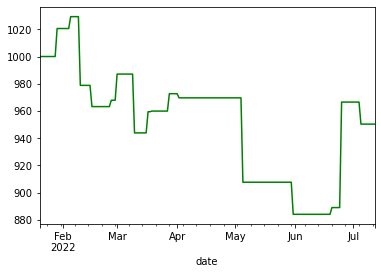

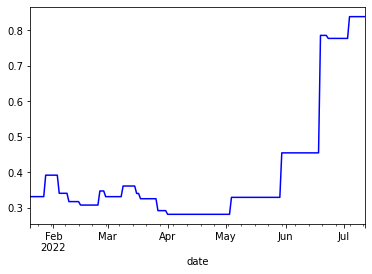

In [23]:
validation['money'].plot(color='g', label = 'money')
plt.show()

validation['eth'].plot(color='b', label = 'eth')
plt.show()

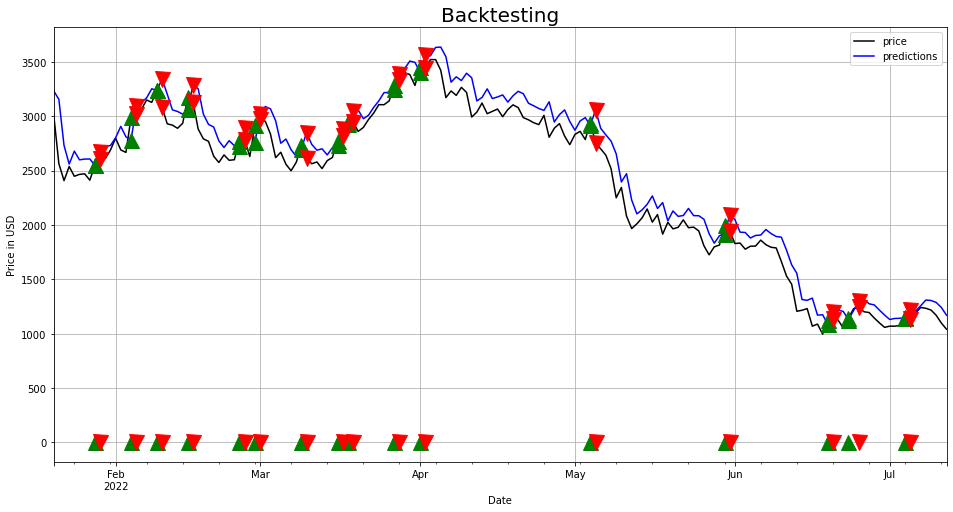

In [24]:
# bear
validation = validation[['ethereum', 'Predictions', 'signal']]
plt.figure(figsize = (16, 8))
validation['ethereum'].plot(color='k', label = 'price')
validation['Predictions'].plot(color='b', label='predictions')
plt.plot(validation[validation['signal']==1].index, validation[validation['signal']==1],'^', markersize = 15, color='g')
plt.plot(validation[validation['signal']==-1].index, validation[validation['signal']==-1],'v', markersize = 15, color='r')
plt.ylabel('Price in USD')
plt.xlabel('Date')
plt.title('Backtesting', fontsize = 20)
plt.legend()
plt.grid()
plt.show()